In [1]:
import tensorflow as tf
import numpy as np

class Embedder:

    def __init__(self, **kwargs):

        self.kwargs = kwargs
        #kwargs: key word arguments of the postional encoding
        self.create_embedding_fn()

    def create_embedding_fn(self):

        embed_fns = []
        # empty list of input spatial or directional functions
        d = self.kwargs['input_dims'] # d = 3
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x: x)
            # add the input spatial or directional to the list
            # (x, y, z) or (dx, dy, dz)
            out_dim += d
            # output dimension is 3 for now

        max_freq = self.kwargs['max_freq_log2'] # L-1
        N_freqs = self.kwargs['num_freqs'] # L

        if self.kwargs['log_sampling']:
            freq_bands = 2.**tf.linspace(0., max_freq, N_freqs)
            #[2^0, 2^1, 2^2, ..., 2^(L-1)](tensor)
        else:
            freq_bands = tf.linspace(2.**0., 2.**max_freq, N_freqs)
            #linspace(1, 2^(L-1), L)(tensor)

        for freq in freq_bands:
            # get each L
            for p_fn in self.kwargs['periodic_fns']:
                # add cos and sin functions
                embed_fns.append(lambda x, p_fn=p_fn,
                                 freq=freq: p_fn(x * freq))
                # x is a tensor of (x, y, z) or (dx, dy, dz)
                # add the positional encoding functions to the functions list
                out_dim += d
                # the list looks like [x,y,z,sin(x),sin(y),sin(z),cos(x),cos(y),cos(z),sin(2x),sin(2y),sin(2z),cos(2x),cos(2y),cos(2z),sin(2^2x),sin(2^2y),sin(2^2z),cos(2^2x),cos(2^2y),cos(2^2z),...]

        self.embed_fns = embed_fns
        self.out_dim = out_dim

    def embed(self, inputs):
        return tf.concat([fn(inputs) for fn in self.embed_fns], -1)
        # here is the positional encoding arrays instead of functions


def get_embedder(multires, i=0):
    # multire: the L of positional encoding in the paper
    # set the parameter of the positional encoding

    if i == -1:
        return tf.identity, 3
    # if i == -1, don't do positional encoding
    # else, do positional encoding

    embed_kwargs = {
        'include_input': True,
        # include input spatial or directional, so the final input dimension is 3+3*2*L
        'input_dims': 3,
        # since NeRF separates positional encoding for spatial and directional, the input dimension is 3 
        'max_freq_log2': multires-1,
        'num_freqs': multires,
        #[0, 1, 2, ..., L-1]
        'log_sampling': True,
        #[2^0, 2^1, 2^2, ..., 2^(L-1)]
        'periodic_fns': [tf.math.sin, tf.math.cos],
    }

    embedder_obj = Embedder(**embed_kwargs)
    # send to Embedder class, and finish the positional encoding
    def embed(x, eo=embedder_obj): return eo.embed(x)
    # return the positional encoding functions but has compute the arrays
    return embed, embedder_obj.out_dim
    # return the output functions and the output dimension

In [2]:
# Example input tensor
input_tensor = tf.constant([[1.0, 2.0, 3.0]])

# Get the embed function and output dimension
embed, dim = get_embedder(3)

# Apply the embed function to the input tensor
encoded_tensor = embed(input_tensor)

print("Encoded Tensor:", encoded_tensor)
print("Output Dimension:", dim)

Encoded Tensor: tf.Tensor(
[[ 1.          2.          3.          0.84147096  0.9092974   0.14112
   0.5403023  -0.41614684 -0.9899925   0.9092974  -0.7568025  -0.2794155
  -0.41614684 -0.6536436   0.96017027 -0.7568025   0.98935825 -0.53657293
  -0.6536436  -0.14550003  0.84385395]], shape=(1, 21), dtype=float32)
Output Dimension: 21


In [36]:

import os
import imageio
data = np.load('train_data/nerf_llff_data/fern/poses_bounds.npy')

poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
bds = poses_arr[:, -2:].transpose([1,0])

basedir = 'train_data/flower'
imgdir = os.path.join(basedir, 'images_8')
imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
sh = imageio.imread(imgfiles[0]).shape
poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
poses[2, 4, :] = poses[2, 4, :] * 1./8.


[ 2.24225156e-02  9.89630739e-01 -1.41873998e-01 -3.67917907e+00
  3.02400000e+03  9.99121012e-01 -2.72090794e-02 -3.18884009e-02
 -1.60379162e+00  4.03200000e+03 -3.54180026e-02 -1.41034274e-01
 -9.89370961e-01 -2.76802064e-01  3.26052633e+03  1.77470875e+01
  7.82574871e+01]


In [30]:
import os
#os.rmdir('train_data/images_8')
basedir = 'train_data'
imgdir = os.path.join(basedir, 'images_{}'.format(8))
if not os.path.exists(imgdir):
    print('no') 
#os.makedirs(imgdir)
if os.path.exists(imgdir):
    print('yes')
if not os.listdir(imgdir):
    print('nothing') 
if os.listdir(imgdir):
    print(os.listdir(imgdir))

yes
['.DS_Store']


In [26]:
imgdir = os.path.join(basedir, 'images_{}x{}'.format(2,3))
os.makedirs(imgdir)

101
101


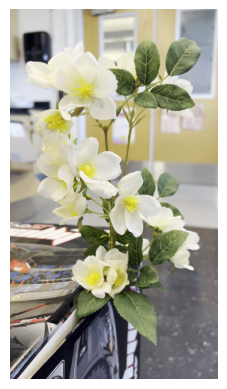

In [7]:
import cv2
import matplotlib.pyplot as plt
import os

basedir = 'train_data/flower'
imgdir = os.path.join(basedir, 'images')
imgs = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir))]
print(len(imgs))
imgs = [f for f in imgs if any([f.endswith(ex) for ex in ['JPG', 'jpg', 'png', 'jpeg', 'PNG']])]
print(len(imgs))
img = cv2.imread(imgs[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
a = []
b = [[1,2,3]]
c = a + b
print(c)

[[1, 2, 3]]


In [10]:
isinstance(2.0, int)

False

In [66]:
import numpy as np
import os
import imageio

poses_arr = np.array([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q']])
poses_arr = np.load(os.path.join(basedir, 'poses_bounds.npy'))
poses_arr = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
])
poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
bds = poses_arr[:, -2:].transpose([1,0])

print(poses.shape)
print(bds.shape)

print(poses)
print(bds)

basedir = 'train_data/flower'
imgdir = os.path.join(basedir, 'images_8')
imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
sh = imageio.imread(imgfiles[0]).shape
print(sh)
print(np.array(sh[:2]).reshape([2, 1]))
poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
print(poses)
poses[2, 4, :] = poses[2, 4, :] * 1./8.
print(poses[2,4,0])
    

(3, 5, 2)
(2, 2)
[[[ 1 18]
  [ 2 19]
  [ 3 20]
  [ 4 21]
  [ 5 22]]

 [[ 6 23]
  [ 7 24]
  [ 8 25]
  [ 9 26]
  [10 27]]

 [[11 28]
  [12 29]
  [13 30]
  [14 31]
  [15 32]]]
[[16 33]
 [17 34]]
(480, 270, 3)
[[480]
 [270]]
[[[  1  18]
  [  2  19]
  [  3  20]
  [  4  21]
  [480 480]]

 [[  6  23]
  [  7  24]
  [  8  25]
  [  9  26]
  [270 270]]

 [[ 11  28]
  [ 12  29]
  [ 13  30]
  [ 14  31]
  [ 15  32]]]
1


/var/folders/xx/1n8vnzjj7gqg15zczd9zsvnw0000gn/T/ipykernel_14866/4179337370.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(imgfiles[0]).shape


In [43]:
import imageio
img0 = [os.path.join(basedir, 'images', f) for f in sorted(os.listdir(os.path.join(basedir, 'images'))) \
            if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')][0]
# find the first image in the folder, and get the path
sh = imageio.imread(img0).shape
#get the shpae of the image
print(sh)

(3840, 2160, 3)


/var/folders/xx/1n8vnzjj7gqg15zczd9zsvnw0000gn/T/ipykernel_14866/3208452337.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(img0).shape


In [28]:
import numpy as np
import os
import imageio

# Example numerical data for poses_arr
poses_arr = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
    [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
])

poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
bds = poses_arr[:, -2:].transpose([1, 0])

# print(poses.shape)  # (3, 5, 2)
# print(bds.shape)    # (2, 2)

print(poses)
print(bds)

sh = (480, 270, 3)
poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
print(poses)
poses[2, 4, :] = poses[2, 4, :] * 1./8.
print(poses[2, 4, :]) 
poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
print(poses)
# poses = np.moveaxis(poses, -1, 0).astype(np.float32)
# print(poses)
# bds = np.moveaxis(bds, -1, 0).astype(np.float32)
# print(bds)
# print(poses[:,:3,3])


[[[ 1 18 35]
  [ 2 19 36]
  [ 3 20 37]
  [ 4 21 38]
  [ 5 22 39]]

 [[ 6 23 40]
  [ 7 24 41]
  [ 8 25 42]
  [ 9 26 43]
  [10 27 44]]

 [[11 28 45]
  [12 29 46]
  [13 30 47]
  [14 31 48]
  [15 32 49]]]
[[16 33 50]
 [17 34 51]]
[[[  1  18  35]
  [  2  19  36]
  [  3  20  37]
  [  4  21  38]
  [480 480 480]]

 [[  6  23  40]
  [  7  24  41]
  [  8  25  42]
  [  9  26  43]
  [270 270 270]]

 [[ 11  28  45]
  [ 12  29  46]
  [ 13  30  47]
  [ 14  31  48]
  [ 15  32  49]]]
[1 4 6]
[[[  2  19  36]
  [ -1 -18 -35]
  [  3  20  37]
  [  4  21  38]
  [480 480 480]]

 [[  7  24  41]
  [ -6 -23 -40]
  [  8  25  42]
  [  9  26  43]
  [270 270 270]]

 [[ 12  29  46]
  [-11 -28 -45]
  [ 13  30  47]
  [ 14  31  48]
  [  1   4   6]]]


In [77]:
import numpy as np

a = np.array([[1,2,3],
              [4,5,6]])
print(a.shape)

(2, 3)


In [11]:
import numpy as np
x = np.array([[1,2],
              [4,5],
              [7,8],])
a = x.shape
print(a)

(3, 2)


In [6]:
a = 0
for i in range(10):
    a = a + i**2
print(a)
print(np.sqrt(a))

285
16.881943016134134


In [15]:
bottom = np.reshape([0, 0, 0, 1.], [1, 4])
print(bottom)

[[0. 0. 0. 1.]]


In [17]:
a =np.array([[1],[2],[3]])
b = np.array([[4],[5],[6]])
c = sum([a,b],[0])
print(c)

[[5]
 [7]
 [9]]


In [27]:
import numpy as np

def normalize(x):
    return x / np.linalg.norm(x)

# Example poses array with shape (N, 3, 5)
# Let's create a small example with N=2 for simplicity
poses = np.array([
    [[1, 0, 1, 1, 4], [0, 1, 0, 2, 1.5], [0, 0, 1, 3, 2]],
    [[0, 1, 1, 4, 412], [1, 0, 0, 5, 5], [0, 0, 1, 6, 34]]
])
print("Poses:")
print(poses)
hwf = poses[0, :3, -1:]
print("hwf` :", hwf)
# Compute the average position (center) of all poses
center = poses[:, :3, 3].mean(0)
print("center:", center)

# Compute the average viewing direction (vec2) of all poses
vec2 = normalize(poses[:, :3, 2].sum(0))
print("vec2:", vec2)

up = poses[:, :3, 1].sum(0)
print("up:", up)

vec0 = normalize(np.cross(up, vec2))
vec1 = normalize(np.cross(vec2, vec0))
v = vec0 * vec1
print("vec0:", vec0)
print("vec1:", vec1)
print("v:", v)

Poses:
[[[  1.    0.    1.    1.    4. ]
  [  0.    1.    0.    2.    1.5]
  [  0.    0.    1.    3.    2. ]]

 [[  0.    1.    1.    4.  412. ]
  [  1.    0.    0.    5.    5. ]
  [  0.    0.    1.    6.   34. ]]]
hwf` : [[4. ]
 [1.5]
 [2. ]]
center: [2.5 3.5 4.5]
vec2: [0.70710678 0.         0.70710678]
up: [1. 1. 0.]
vec0: [ 0.57735027 -0.57735027 -0.57735027]
vec1: [ 0.40824829  0.81649658 -0.40824829]
v: [ 0.23570226 -0.47140452  0.23570226]


In [30]:
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])
x = np.cross(z,y)
print(x)

[-1  0  0]


In [42]:
import numpy as np
vec0 = np.array([1, 523, 51])
vec1 = np.array([56, 1, 3457])
vec2 = np.array([263, 6314, 1])
pos = np.array([125, 512, 56123])
m = np.stack([vec0, vec1, vec2, pos], 1)
print(m)
hwf = np.array([[15], [232], [55223]])
m = np.concatenate([m,hwf], 1)
print(m)

[[    1    56   263   125]
 [  523     1  6314   512]
 [   51  3457     1 56123]]
[[    1    56   263   125    15]
 [  523     1  6314   512   232]
 [   51  3457     1 56123 55223]]


In [20]:
import numpy as np
import os, imageio


########## Slightly modified version of LLFF data loading code 
##########  see https://github.com/Fyusion/LLFF for original

# resize images, basedir: images directory, factor : integer, resolution: [H,W] list
# so basically this function will take the images folder in the object
# then create the images_8 folder, and put resized images in it
# if the original images are not png, delete the original images in images_8 folder
def _minify(basedir, factors=[], resolutions=[]):
    needtoload = False
    for r in factors:
        imgdir = os.path.join(basedir, 'images_{}'.format(r))
        # create a directory, name images_{factor number}
        if not os.path.exists(imgdir):
            # if the folder does not exist, 
            needtoload = True
    for r in resolutions:
        imgdir = os.path.join(basedir, 'images_{}x{}'.format(r[1], r[0]))
        if not os.path.exists(imgdir):
            needtoload = True
        # same as above
    if not needtoload:
        return
    # so this part check whether both folder exits, if anyone is missing, we need to load the images
    # if there are these two folders then quit the minify function
    # however this part only check the folder's existence,
    # not check whether the folders are empty or not
    
    from shutil import copy
    from subprocess import check_output
    
    imgdir = os.path.join(basedir, 'images')
    # find the images folder
    imgs = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir))]
    # get all the images in the folder and sort them in order
    imgs = [f for f in imgs if any([f.endswith(ex) for ex in ['JPG', 'jpg', 'png', 'jpeg', 'PNG']])]
    # only take certain types of images
    imgdir_orig = imgdir
    #imgdir = data/object/images
    
    wd = os.getcwd()
    # get the current working directory

    for r in factors + resolutions:
        # concatenate the two lists, since factors is list of integer
        # and resolutions is list of list, then it will be a list like [integer1, [interger2, integer3]]
        # so basically this loop will iterate through the two elements of the list, an integer and a list
        if isinstance(r, int):
            name = 'images_{}'.format(r)
            resizearg = '{}%'.format(100./r)
        else:
            name = 'images_{}x{}'.format(r[1], r[0])
            resizearg = '{}x{}'.format(r[1], r[0])
        # create image folder name like images_8 or images_256x256
        imgdir = os.path.join(basedir, name)
        # create directory path name
        if os.path.exists(imgdir):
            continue
            
        print('Minifying', r, basedir)
        
        os.makedirs(imgdir)
        # create the directory just named above, images_8
        check_output('cp {}/* {}'.format(imgdir_orig, imgdir), shell=True)
        # copy images from the original folder to the new folder images_8
        
        ext = imgs[0].split('.')[-1]
        # take the file type of the image, like jpg or png
        args = ' '.join(['mogrify', '-resize', resizearg, '-format', 'png', '*.{}'.format(ext)])
        # create a string like 'mogrify -resize 12.5% -format png *.jpg'
        # this command will resize the images in the folder, and convert them to png format
        print(args)
        os.chdir(imgdir)
        # change from the basedir to the new folder iamges_8
        check_output(args, shell=True)
        # execute the command
        os.chdir(wd)
        
        if ext != 'png':
            check_output('rm {}/*.{}'.format(imgdir, ext), shell=True)
            print('Removed duplicates')
        # if the original image is not png, then remove the original images in the folder images_8
        print('Done')
            
        
        

# this function take the pose_bounds.npy file and images folder, and return the poses (3*5*N), bounds(2*N), and images(H*W*C*N)
def _load_data(basedir, factor=None, width=None, height=None, load_imgs=True):
    
    poses_arr = np.load(os.path.join(basedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    # Step-by-step transformation:
    # N*17 -> N*15 -> N*3*5 -> 3*5*N
    # 1. poses_arr[:, :-2] → Extracts the first 15 columns (shape: (N, 15))
    # 2. .reshape([-1, 3, 5]) → Reshapes into (N, 3, 5), treating each pose as a 3×5 matrix
    # the -1 at first means the first axis number will be computed by numpy after the last two axis become 3*5
    # 3. .transpose([1, 2, 0]) → Rearranges axes to (3, 5, N)
    #    - `3` → Rotation matrix rows
    #    - `5` → Rotation + translation matrix columns
    #    - `N` → Number of samples

    # [
    #    [[a1, b1, c1, ...], [[a6,  b6,  c6, ...],  [[a11,  b11,  c11, ...],
    #     [a2, b2, c2, ...],  [a7,  b7,  c7, ...],   [a12,  b12,  c12, ...],
    #     [a3, b3, c3, ...],  [a8,  b8,  c8, ...],   [a13,  b13,  c13, ...],
    #     [a4, b4, c4, ...],  [a9,  b9,  c9, ...],   [a14,  b14,  c14, ...],
    #     [a5, b5, c5, ...]], [a10, b10, c10, ...]], [a15,  b15,  c15, ...],
    # ]
    bds = poses_arr[:, -2:].transpose([1,0])
    # Step-by-step transformation:
    # N*17 -> N*2 -> 2*N
    # 1. poses_arr[:, -2:] → Extracts the last two columns (shape: (N, 2))
    # 2. .transpose([1, 0]) → Swaps axes to (2, N), making:
    # [
    #    [a16, b16, c16, ...],  # Near bounds (row 1)
    #    [a17, b17, c17, ...]   # Far bounds (row 2)
    # ]
    
    
    img0 = [os.path.join(basedir, 'images', f) for f in sorted(os.listdir(os.path.join(basedir, 'images'))) \
            if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')][0]
    # find the first image in the folder, and get the path
    sh = imageio.imread(img0).shape
    #get the shpae of the image
    
    sfx = ''
    # this is the suffix of the folder name, like images_8 or images_256x256, so that it can find the folder later
    
    #this part prioritize the factor input, if there is factor input, then resize the images by the factor
    if factor is not None:
        sfx = '_{}'.format(factor)
        _minify(basedir, factors=[factor])
        factor = factor
    # if there is factor input, the resize the images by the factor and put all images in the folder images_{factor}
    elif height is not None:
        factor = sh[0] / float(height)
        width = int(sh[1] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    # if there is resolution input, the resize the images into the resolution and put all images in the folder images_{width}x{height}
    # the new height will be the input height, and the width will be calculated by the factor by original_height / new_height
    elif width is not None:
        factor = sh[1] / float(width)
        height = int(sh[0] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    else:
        factor = 1
    
    # find the images folder with the suffix, images_8
    imgdir = os.path.join(basedir, 'images' + sfx)
    if not os.path.exists(imgdir):
        print( imgdir, 'does not exist, returning' )
        return
    
    # find all the images directory
    imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
    if poses.shape[-1] != len(imgfiles):
        # if the poses and images numbers are not matched, then print the error message
        print( 'Mismatch between imgs {} and poses {} !!!!'.format(len(imgfiles), poses.shape[-1]) )
        return
    
    sh = imageio.imread(imgfiles[0]).shape
    # (H, W, C)
    poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
    # Updates:
    # - Selects the last column (index 4) of the first two 3x5*N matrices**.
    # - Replaces it with the height (H) and width (W) of the image.
    # [
    #    [[a1, b1, c1, ...], [[a6,  b6,  c6, ...],  [[a11,  b11,  c11, ...],
    #     [a2, b2, c2, ...],  [a7,  b7,  c7, ...],   [a12,  b12,  c12, ...],
    #     [a3, b3, c3, ...],  [a8,  b8,  c8, ...],   [a13,  b13,  c13, ...],
    #     [a4, b4, c4, ...],  [a9,  b9,  c9, ...],   [a14,  b14,  c14, ...],
    #     [H,  H,  H, ...]],  [W,   W,   W, ...]],   [a15,  b15,  c15, ...],
    # ]
    poses[2, 4, :] = poses[2, 4, :] * 1./factor
    # - Selects the **last column (index 4) of the third 3x5*N matrix**.
    # - Divides its values by `factor`.

    # [
    #    [[a1, b1, c1, ...], [[a6,  b6,  c6, ...],  [[a11,  b11,  c11, ...],
    #     [a2, b2, c2, ...],  [a7,  b7,  c7, ...],   [a12,  b12,  c12, ...],
    #     [a3, b3, c3, ...],  [a8,  b8,  c8, ...],   [a13,  b13,  c13, ...],
    #     [a4, b4, c4, ...],  [a9,  b9,  c9, ...],   [a14,  b14,  c14, ...],
    #     [H,  H,  H, ...]],  [W,   W,   W, ...]],   [a15/factor,  b15/factor,  c15/factor, ...],
    # ]
    
    if not load_imgs:
        return poses, bds
    
    # if it is png, ignore the gamma
    def imread(f):
        if f.endswith('png'):
            # return imageio.imread(f, ignoregamma=True)
            return imageio.imread(f, apply_gamma=False)
        else:
            return imageio.imread(f)
    
    imgs = imgs = [imread(f)[...,:3]/255. for f in imgfiles]
    # read all the images in the folder, and only take the first three channels RGB, and normalize the image to [0,1]
    imgs = np.stack(imgs, -1)
    # stack all the images together, so the shape will be (H, W, C, N)
    # A big H × W matrix, where each “cell” (pixel) contains a 3 × N matrix.
    # This 3 × N matrix stores the RGB values of that pixel across all N images.
    # Picture style:
    # [
    #    [[R11_1, R11_2, R1_3, ... R11_N],  [[R12_1,  R12_2,  R12_3, ... R12_N],  [[R13_1,  R13_2,  R13_3, ... R13_N],  ... [[R1W_1,  R1W_2,  R1W_3, ... R1W_N],
    #     [G11_1, G11_2, G1_3, ... G11_N],   [G12_1,  G12_2,  G12_3, ... G12_N],   [G13_1,  G13_2,  G13_3, ... G13_N],  ...  [G1W_1,  G1W_2,  G1W_3, ... G1W_N],
    #     [B11_1, B11_2, B1_3, ... B11_N]],  [B12_1,  B12_2,  B12_3, ... B12_N]],  [B13_1,  B13_2,  B13_3, ... B13_N]], ...  [B1W_1,  B1W_2,  B1W_3, ... B1W_N]],  
    #
    #    [[R21_1, R21_2, R2_3, ... R21_N],  [[R22_1,  R22_2,  R22_3, ... R22_N],  [[R23_1,  R23_2,  R23_3, ... R23_N],  ... [[R2W_1,  R2W_2,  R2W_3, ... R2W_N],
    #     [G21_1, G21_2, G2_3, ... G21_N],   [G22_1,  G22_2,  G22_3, ... G22_N],   [G23_1,  G23_2,  G23_3, ... G23_N],  ...  [G2W_1,  G2W_2,  G2W_3, ... G2W_N],
    #     [B21_1, B21_2, B2_3, ... B21_N]],  [B22_1,  B22_2,  B22_3, ... B22_N]],  [B23_1,  B23_2,  B23_3, ... B23_N]], ...  [B2W_1,  B2W_2,  B2W_3, ... B2W_N]],
    #
    #    [[R31_1, R31_2, R3_3, ... R31_N],  [[R32_1,  R32_2,  R32_3, ... R32_N],  [[R33_1,  R33_2,  R33_3, ... R33_N],  ... [[R3W_1,  R3W_2,  R3W_3, ... R3W_N],
    #     [G31_1, G31_2, G3_3, ... G31_N],   [G32_1,  G32_2,  G32_3, ... G32_N],   [G33_1,  G33_2,  G33_3, ... G33_N],  ...  [G3W_1,  G3W_2,  G3W_3, ... G3W_N],
    #     [B31_1, B31_2, B3_3, ... B31_N]],  [B32_1,  B32_2,  B32_3, ... B32_N]],  [B33_1,  B33_2,  B33_3, ... B33_N]], ...  [B3W_1,  B3W_2,  B3W_3, ... B3W_N]],
    #    ...
    #    [[RH1_1, RH1_2, RH_3, ... RH1_N],  [[RH2_1,  RH2_2,  RH2_3, ... RH2_N],  [[RH3_1,  RH3_2,  RH3_3, ... RH3_N],  ... [[RHW_1,  RHW_2,  RHW_3, ... RHW_N],
    #     [GH1_1, GH1_2, GH_3, ... GH1_N],   [GH2_1,  GH2_2,  GH2_3, ... GH2_N],   [GH3_1,  GH3_2,  GH3_3, ... GH3_N],  ...  [GHW_1,  GHW_2,  GHW_3, ... GHW_N],
    #     [BH1_1, BH1_2, BH_3, ... BH1_N]],  [BH2_1,  BH2_2,  BH2_3, ... BH2_N]],  [BH3_1,  BH3_2,  BH3_3, ... BH3_N]], ...  [BHW_1,  BHW_2,  BHW_3, ... BHW_N]],
    # ]
    # OR
    # Numpy style:
    # [
    #   [ 
    #     [[R11_1, R11_2, ..., R11_N],  [G11_1, G11_2, ..., G11_N],  [B11_1, B11_2, ..., B11_N]],  # Pixel (0,0)
    #     [[R12_1, R12_2, ..., R12_N],  [G12_1, G12_2, ..., G12_N],  [B12_1, B12_2, ..., B12_N]],  # Pixel (0,1)
    #     [[R13_1, R13_2, ..., R13_N],  [G13_1, G13_2, ..., G13_N],  [B13_1, B13_2, ..., B13_N]],  # Pixel (0,2)
    #     ... 
    #     [[R1W_1, R1W_2, ..., R1W_N],  [G1W_1, G1W_2, ..., G1W_N],  [B1W_1, B1W_2, ..., B1W_N]]  # Pixel (0,W-1)
    #   ], # Row 0
    #
    #   [ 
    #     [[R21_1, R21_2, ..., R21_N],  [G21_1, G21_2, ..., G21_N],  [B21_1, B21_2, ..., B21_N]],  # Pixel (1,0)
    #     [[R22_1, R22_2, ..., R22_N],  [G22_1, G22_2, ..., G22_N],  [B22_1, B22_2, ..., B22_N]],  # Pixel (1,1)
    #     [[R23_1, R23_2, ..., R23_N],  [G23_1, G23_2, ..., G23_N],  [B23_1, B23_2, ..., B23_N]],  # Pixel (1,2)
    #     ... 
    #     [[R2W_1, R2W_2, ..., R2W_N],  [G2W_1, G2W_2, ..., G2W_N],  [B2W_1, B2W_2, ..., B2W_N]]  # Pixel (1,W-1)
    #   ], # Row 1
    #
    #   ...
    #
    #   [ 
    #     [[RH1_1, RH1_2, ..., RH1_N],  [GH1_1, GH1_2, ..., GH1_N],  [BH1_1, BH1_2, ..., BH1_N]],  # Pixel (H-1,0)
    #     [[RH2_1, RH2_2, ..., RH2_N],  [GH2_1, GH2_2, ..., GH2_N],  [BH2_1, BH2_2, ..., BH2_N]],  # Pixel (H-1,1)
    #     [[RH3_1, RH3_2, ..., RH3_N],  [GH3_1, GH3_2, ..., GH3_N],  [BH3_1, BH3_2, ..., BH3_N]],  # Pixel (H-1,2)
    #     ... 
    #     [[RHW_1, RHW_2, ..., RHW_N],  [GHW_1, GHW_2, ..., GHW_N],  [BHW_1, BHW_2, ..., BHW_N]]  # Pixel (H-1,W-1)
    #   ] # Row H-1
    # ]
    print('Loaded image data', imgs.shape, poses[:,-1,0])
    return poses, bds, imgs

    
            
            
    

def normalize(x):
    return x / np.linalg.norm(x)
# return the original matrix devided by the L2 Norm of array x (sqrt(sum(x**2)))

def viewmatrix(z, up, pos):
    """
    This is a tricky part, everything is in NeRF's camera coordinate system
    For up, since in COLMAP, the positive Y-axis is downward, and the world coordinate system is up-postive
    So the y value is negative, so it is negated in the load_llff_data(),
    so it is point up right now in NeRF's camera coordinate system
    For z, in COLMAP, the positive Z-axis is forward, in NeRF, the positive Z-axis is backward
    However, if we just put the positive value of Z into this function, it will directly point to the backward
    """
    # z: viewing direction, vec2, (3,)
    # up: up direction, Y, (3,)
    # pos: camera's position in world space, space, center, (3,)
    vec2 = normalize(z)
    # normalize the viewing direction to unit vector
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    """
    # compute the rightward X-axis direction of the camera, not very sure about whether right or left
    """
    # using cross product of up and viewing direction make sure this vector is perpendicular to both Y and Z
    # cross product: produce a perpendicular vector to the plane of the two input vectors
    vec1 = normalize(np.cross(vec2, vec0))
    # recompute the Y(up) direction of the camera, make sure this vector is perpendicular to both Z and X
    
    m = np.stack([vec0, vec1, vec2, pos], 1)
    # so this one is actually not the homogeneous transformation matrix
    # it is only the camera axis' axis projection in world space
    return m

def ptstocam(pts, c2w):
    tt = np.matmul(c2w[:3,:3].T, (pts-c2w[:3,3])[...,np.newaxis])[...,0]
    return tt

def poses_avg(poses):
    # poses: (N,3,5)
    hwf = poses[0, :3, -1:]
    # shape: (3,1)
    # the forth column represent the camera translation value
    # Extracts the height, width, and focal length (hwf) from the first pose.
    # assume all camera have the same intrinsic parameters
    # take the last column of the first 3*5 matrix
    # [[[a2,  -a1,  a3,  a4*sc,  H]
    #   [a7,  -a6.  a8,  a9*sc,  W]
    #   [a12, -a11, a13, a14*sc, a15/factor]]
    center = poses[:, :3, 3].mean(0)
    # shape: (3,)
    # compute the average position/center of all poses
    # take all the 3*5 matrix's 4th column, and take the mean of them along the rows
    vec2 = normalize(poses[:, :3, 2].sum(0))
    # shape: (3,)
    # Computes the summation of Z(viewing direction) of all poses.
    # take the 3rd column of all 3*5 matrix, and sum them up along the rows, then normalize the sum
    up = poses[:, :3, 1].sum(0)
    # shape: (3,)
    # Computes the summation up direction Y(up) of all poses.
    # take the 2nd column of all 3*5 matrix, and sum them up along the rows
    
    c2w = np.concatenate([viewmatrix(vec2, up, center), hwf], 1)
    
    return c2w



def render_path_spiral(c2w, up, rads, focal, zdelta, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    hwf = c2w[:,4:5]
    
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(np.concatenate([viewmatrix(z, up, c), hwf], 1))
    return render_poses
    


def recenter_poses(poses):
    # poses: (N,3,5)

    poses_ = poses+0
    # make a copy of poses
    bottom = np.reshape([0,0,0,1.], [1,4])
    # [[0,0,0,1]]
    c2w = poses_avg(poses)
    c2w = np.concatenate([c2w[:3,:4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1,1,4]), [poses.shape[0],1,1])
    poses = np.concatenate([poses[:,:3,:4], bottom], -2)

    poses = np.linalg.inv(c2w) @ poses
    poses_[:,:3,:4] = poses[:,:3,:4]
    poses = poses_
    return poses


#####################


def spherify_poses(poses, bds):
    
    p34_to_44 = lambda p : np.concatenate([p, np.tile(np.reshape(np.eye(4)[-1,:], [1,1,4]), [p.shape[0], 1,1])], 1)
    
    rays_d = poses[:,:3,2:3]
    rays_o = poses[:,:3,3:4]

    def min_line_dist(rays_o, rays_d):
        A_i = np.eye(3) - rays_d * np.transpose(rays_d, [0,2,1])
        b_i = -A_i @ rays_o
        pt_mindist = np.squeeze(-np.linalg.inv((np.transpose(A_i, [0,2,1]) @ A_i).mean(0)) @ (b_i).mean(0))
        return pt_mindist

    pt_mindist = min_line_dist(rays_o, rays_d)
    
    center = pt_mindist
    up = (poses[:,:3,3] - center).mean(0)

    vec0 = normalize(up)
    vec1 = normalize(np.cross([.1,.2,.3], vec0))
    vec2 = normalize(np.cross(vec0, vec1))
    pos = center
    c2w = np.stack([vec1, vec2, vec0, pos], 1)

    poses_reset = np.linalg.inv(p34_to_44(c2w[None])) @ p34_to_44(poses[:,:3,:4])

    rad = np.sqrt(np.mean(np.sum(np.square(poses_reset[:,:3,3]), -1)))
    
    sc = 1./rad
    poses_reset[:,:3,3] *= sc
    bds *= sc
    rad *= sc
    
    centroid = np.mean(poses_reset[:,:3,3], 0)
    zh = centroid[2]
    radcircle = np.sqrt(rad**2-zh**2)
    new_poses = []
    
    for th in np.linspace(0.,2.*np.pi, 120):

        camorigin = np.array([radcircle * np.cos(th), radcircle * np.sin(th), zh])
        up = np.array([0,0,-1.])

        vec2 = normalize(camorigin)
        vec0 = normalize(np.cross(vec2, up))
        vec1 = normalize(np.cross(vec2, vec0))
        pos = camorigin
        p = np.stack([vec0, vec1, vec2, pos], 1)

        new_poses.append(p)

    new_poses = np.stack(new_poses, 0)
    
    new_poses = np.concatenate([new_poses, np.broadcast_to(poses[0,:3,-1:], new_poses[:,:3,-1:].shape)], -1)
    poses_reset = np.concatenate([poses_reset[:,:3,:4], np.broadcast_to(poses[0,:3,-1:], poses_reset[:,:3,-1:].shape)], -1)
    
    return poses_reset, new_poses, bds
    

def load_llff_data(basedir, factor=8, recenter=True, bd_factor=.75, spherify=False, path_zflat=False):
    

    poses, bds, imgs = _load_data(basedir, factor=factor) # factor=8 downsamples original imgs by 8x
    print('Loaded', basedir, bds.min(), bds.max())
    
    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    """
    # In COLMAP, the coordinate is [Y(down), X(right), Z(foward)]
    # But in NeRF, the coordinate is [X(right), Y(up), Z(backward)]
    #
    # So we need to swap 1st and 2nd and multiply -1 to 1st
    #
    # However, the reason don't negate the 3rd is :
    # In COLMAP, the Z-axis represents depth and points forward from the camera.
	# In NeRF, the Z-axis still represents depth, but it is interpreted as negative along the viewing direction.
    #
    # Take the second row of each 5*N matrix, to the  first row
    # take the first two to second two, multiply by -1
    # and keep the reset the same
    """
    # [
    #    [[a2, b2, c2, ...],   [[a7,  b7,  c7, ...],   [[a12,  b12,  c12, ...],,
    #    [-a1,-b1,-c1, ...],  [-a6, -b6, -c6, ...],    [-a11, -b11, -c11, ...],
    #     [a3, b3, c3, ...],    [a8,  b8,  c8, ...],    [a13,  b13,  c13, ...],
    #     [a4, b4, c4, ...],    [a9,  b9,  c9, ...],    [a14,  b14,  c14, ...],
    #     [H,  H,  H, ...]],    [W,   W,   W, ...]],    [a15/factor,  b15/factor,  c15/factor, ...],
    # ]
    
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    print(poses[0])
    # move the last axis to the first axis, so the shape will be (N, 3, 5)
    """
    # The first three columns are the [X(right), Y(up), Z(forward)] of camera's coordinate system in world space
    # The forth column is the translation vector of the camera (camera position) in world space
    """
    # [[[a2,  -a1,  a3,  a4,  H]
    #   [a7,  -a6.  a8,  a9,  W]
    #   [a12, -a11, a13, a14, a15/factor]]
    #
    # [[[b2,  -b1,  b3,  b4,  H]
    #   [b7,  -b6.  b8,  b9,  W]
    #   [b12, -b11, b13, b14, b15/factor]]
    #
    # [[[c2,  -c1,  c3,  c4,  H]
    #   [c7,  -c6.  c8,  c9,  W]
    #   [c12, -c11, c13, c14, c15/factor]]
    #    ...
    
    imgs = np.moveaxis(imgs, -1, 0).astype(np.float32)
    # move the last axis to the first axis, so the shape will be (N, H, W, C)
    images = imgs
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    # move the last axis to the first axis, so the shape will be (N, 2)
    # [[a16,a17], 
    #  [b16,b17], 
    #  [c16,c17], 
    #   .........]
    
    # Rescale if bd_factor is provided
    sc = 1. if bd_factor is None else 1./(bds.min() * bd_factor)
    # if there is bd_factor input, then sc = 1 / (min(bds) * bd_factor)
    poses[:,:3,3] *= sc
    # This normalizes the scene scale so that the smallest bound is 1.0.
    # take each 3*5 Matrix's 4th column multiply by sc
    
    # [[[a2,  -a1,  a3,  a4*sc,  H]
    #   [a7,  -a6.  a8,  a9*sc,  W]
    #   [a12, -a11, a13, a14*sc, a15/factor]]
    #
    # [[[b2,  -b1,  b3,  b4*sc,  H]
    #   [b7,  -b6.  b8,  b9*sc,  W]
    #   [b12, -b11, b13, b14*sc, b15/factor]]
    #
    # [[[c2,  -c1,  c3,  c4*sc,  H]
    #   [c7,  -c6.  c8,  c9*sc,  W]
    #   [c12, -c11, c13, c14*sc, c15/factor]]
    #    ...
    bds *= sc
    # multiply bds by sc
    # [[a16,a17], 
    #  [b16,b17], 
    #  [c16,c17], 
    #   .........] * 1 / (min(bds) * bd_factor)
    # so there will be an element value in bds is bd_factor
    
    if recenter:
        poses = recenter_poses(poses)
        print('step1')
        
    if spherify:
        poses, render_poses, bds = spherify_poses(poses, bds)
        print('step2')

    else:
        print('step3')
        c2w = poses_avg(poses)
        print('recentered', c2w.shape)
        print(c2w[:3,:4])

        ## Get spiral
        # Get average pose
        up = normalize(poses[:, :3, 1].sum(0))

        # Find a reasonable "focus depth" for this dataset
        close_depth, inf_depth = bds.min()*.9, bds.max()*5.
        dt = .75
        mean_dz = 1./(((1.-dt)/close_depth + dt/inf_depth))
        focal = mean_dz

        # Get radii for spiral path
        shrink_factor = .8
        zdelta = close_depth * .2
        tt = poses[:,:3,3] # ptstocam(poses[:3,3,:].T, c2w).T
        rads = np.percentile(np.abs(tt), 90, 0)
        c2w_path = c2w
        N_views = 120
        N_rots = 2
        if path_zflat:
#             zloc = np.percentile(tt, 10, 0)[2]
            zloc = -close_depth * .1
            c2w_path[:3,3] = c2w_path[:3,3] + zloc * c2w_path[:3,2]
            rads[2] = 0.
            N_rots = 1
            N_views/=2

        # Generate poses for spiral path
        render_poses = render_path_spiral(c2w_path, up, rads, focal, zdelta, zrate=.5, rots=N_rots, N=N_views)
        
        
    render_poses = np.array(render_poses).astype(np.float32)

    c2w = poses_avg(poses)
    print('Data:')
    print(poses.shape, images.shape, bds.shape)
    
    dists = np.sum(np.square(c2w[:3,3] - poses[:,:3,3]), -1)
    i_test = np.argmin(dists)
    print('HOLDOUT view is', i_test)
    
    images = images.astype(np.float32)
    poses = poses.astype(np.float32)

    return images, poses, bds, render_poses, i_test





In [21]:
i, p, b, r, i_test = load_llff_data('train_data/flower', factor=8, bd_factor=.75, recenter=True, spherify=False, path_zflat=False)

/var/folders/xx/1n8vnzjj7gqg15zczd9zsvnw0000gn/T/ipykernel_66503/1026144013.py:127: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(img0).shape
/var/folders/xx/1n8vnzjj7gqg15zczd9zsvnw0000gn/T/ipykernel_66503/1026144013.py:167: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(imgfiles[0]).shape
/var/folders/xx/1n8vnzjj7gqg15zczd9zsvnw0000gn/T/ipykernel_66503/1026144013.py:199: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear)

Loaded image data (480, 270, 3, 101) [480.         270.         409.04744343]
Loaded train_data/flower 2.0540397513473736 63.18938956199632
[[ 9.9907643e-01  7.3999627e-03 -4.2326558e-02 -6.4267582e-01
   4.8000000e+02]
 [ 7.6971906e-03 -9.9994683e-01  6.8636015e-03  4.8239052e-01
   2.7000000e+02]
 [-4.2273518e-02 -7.1830582e-03 -9.9908024e-01 -3.1928372e+00
   4.0904745e+02]]
step1
step3
recentered (3, 5)
[[ 1.0000000e+00 -1.3199143e-07  2.2742886e-07 -1.5668350e-07]
 [ 1.3199143e-07  1.0000000e+00  2.8902793e-09  2.7736816e-08]
 [-2.2742886e-07 -2.8902494e-09  1.0000000e+00  1.2156987e-07]]
Data:
(101, 3, 5) (101, 480, 270, 3) (101, 2)
HOLDOUT view is 94


In [13]:
import numpy as np
bottom = np.reshape([0,0,0,16.], [1,4])
c2w = np.array([[1, 2, 3, 4, 5],
                [6,7,8,9,10],
                [11,12,13,14,15]])
c2w = np.concatenate([c2w[:3,:4], bottom], 0)
print(c2w)

[[ 1.  2.  3.  4.]
 [ 6.  7.  8.  9.]
 [11. 12. 13. 14.]
 [ 0.  0.  0. 16.]]


In [8]:
bottom = np.array([0,0,0,1.])
print(bottom)
print(np.reshape(bottom, [1,4]))
print(np.reshape(bottom, [1,1,4]))
bottom = np.tile(np.reshape(bottom, [1,1,4]), [10,1,1])
print(bottom)

[0. 0. 0. 1.]
[[0. 0. 0. 1.]]
[[[0. 0. 0. 1.]]]
[[[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]]


In [9]:
import numpy as np

a = np.array([[1, 2], [3, 4]])  # Shape (2, 2)
tiled_a = np.tile(a, [10, 1, 1])
print(tiled_a)

[[[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]]


In [15]:
# Re-import necessary libraries since the execution state was reset
import numpy as np

# Define a camera-to-world transformation matrix (c2w)
# Assume the camera is looking along the Z-axis, with X and Y axes aligned in world space
c2w = np.array([[1, 0, 0, 3],  # X-axis (projected in world space) + translation
                [0, 1, 0, 4],  # Y-axis (projected in world space) + translation
                [0, 0, 1, 5],  # Z-axis (projected in world space) + translation
                [0, 0, 0, 1]]) # Homogeneous coordinate

# Compute the inverse to get world-to-camera transformation (w2c)
w2c = np.linalg.inv(c2w)

# Define a point in world coordinates
point_world = np.array([6, 7, 8, 1])  # A point in the world frame

# Transform the world point into the camera frame using w2c
point_camera = w2c @ point_world

# Transform the camera point back into the world frame using c2w (should recover original)
point_world_recovered = c2w @ point_camera

print('World point:', point_world)
print('Camera point:', point_camera)
print('Recovered world point:', point_world_recovered)

World point: [6 7 8 1]
Camera point: [3. 3. 3. 1.]
Recovered world point: [6. 7. 8. 1.]


In [22]:
a = np.reshape(np.eye(4)[-1,:], [1,1,4])
print(a)

[[[0. 0. 0. 1.]]]


In [45]:
c2w = np.array([[[1, 2, 3, 4, 5],
                [6,7,8,9,10],
                [11,12,13,14,15]],
                [[16, 17, 18, 19, 20],
                [21,22,23,24,25],
                [26,27,28,29,30]]])
print(c2w)
rays_d = c2w[:,:3,2:3]
print(rays_d)
rays_o = c2w[:,:3,3:4]
#print(rays_o)
v = np.transpose(rays_d, [0,2,1])
print(v)
print(rays_d * v)

def min_line_dist(rays_o, rays_d):
        A_i = np.eye(3) - rays_d * np.transpose(rays_d, [0,2,1])
        print('A_i',A_i)
        b_i = -A_i @ rays_o
        print('b_i',b_i)
        pt_mindist = np.squeeze(-np.linalg.inv((np.transpose(A_i, [0,2,1]) @ A_i).mean(0)) @ (b_i).mean(0))
        print('A_t',np.transpose(A_i, [0,2,1]))
        print('A_t_t',np.transpose(A_i, [0,2,1]) @ A_i)
        print('A_t_m',(np.transpose(A_i, [0,2,1]) @ A_i).mean(0))
        print(pt_mindist)
        return pt_mindist
p = min_line_dist(rays_o, rays_d)

[[[ 1  2  3  4  5]
  [ 6  7  8  9 10]
  [11 12 13 14 15]]

 [[16 17 18 19 20]
  [21 22 23 24 25]
  [26 27 28 29 30]]]
[[[ 3]
  [ 8]
  [13]]

 [[18]
  [23]
  [28]]]
[[[ 3  8 13]]

 [[18 23 28]]]
[[[  9  24  39]
  [ 24  64 104]
  [ 39 104 169]]

 [[324 414 504]
  [414 529 644]
  [504 644 784]]]
A_i [[[  -8.  -24.  -39.]
  [ -24.  -63. -104.]
  [ -39. -104. -168.]]

 [[-323. -414. -504.]
  [-414. -528. -644.]
  [-504. -644. -783.]]]
b_i [[[  794.]
  [ 2119.]
  [ 3444.]]

 [[30689.]
  [39214.]
  [47739.]]]
A_t [[[  -8.  -24.  -39.]
  [ -24.  -63. -104.]
  [ -39. -104. -168.]]

 [[-323. -414. -504.]
  [-414. -528. -644.]
  [-504. -644. -783.]]]
A_t_t [[[   2161.    5760.    9360.]
  [   5760.   15361.   24960.]
  [   9360.   24960.   40561.]]

 [[ 529741.  676890.  824040.]
  [ 676890.  864916. 1052940.]
  [ 824040. 1052940. 1281841.]]]
A_t_m [[265951.  341325.  416700. ]
 [341325.  440138.5 538950. ]
 [416700.  538950.  661201. ]]
[ 0.11510365  0.00137075 -0.11236214]


In [43]:
(2161+529741)/2

265951.0

In [20]:
import numpy as np
poses_reset = np.array([[[1, 2, 3, 4, 5],
                [6,7,8,9,10],
                [11,12,13,14,15]],
                [[16, 17, 18, 19, 20],
                [21,22,23,24,25],
                [26,27,28,29,30]]])
centroid = np.mean(poses_reset[:,:3,3], 0)
print(centroid)

[11.5 16.5 21.5]


In [21]:
a = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
b = np.array([[[13, 14, 15]], [[19, 20, 21]]])
poses = np.concatenate([a, b], 1)
print(a)
print(b)
print(poses)

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
[[[13 14 15]]

 [[19 20 21]]]
[[[ 1  2  3]
  [ 4  5  6]
  [13 14 15]]

 [[ 7  8  9]
  [10 11 12]
  [19 20 21]]]


In [25]:
import numpy as np
a = np.arctan2(-1,1)
print(a)

-0.7853981633974483


In [41]:
theta = np.linspace(0, np.pi / 2, 5)  # Elevation angle (0 = top, π/2 = equator), respect to positive Z-axis
print(theta)
    
# Generate azimuthal angles (full circle around Z-axis)
phi = np.linspace(0, 2 * np.pi, 5)  # Azimuth angle (0 = front, 2π = full circle), respect to positive X-axis

# Create a meshgrid for all combinations of theta and phi
theta, phi = np.meshgrid(theta, phi)

# Convert spherical to Cartesian coordinates
x = 2 * np.sin(theta) * np.cos(phi)
y = 2 * np.sin(theta) * np.sin(phi)
z = 2 * np.cos(theta)

# Flatten all arrays and stack into 6D points
points = np.column_stack((x.flatten(), y.flatten(), z.flatten(), theta.flatten(), phi.flatten()))
print(points.shape)


[0.         0.39269908 0.78539816 1.17809725 1.57079633]
(25, 5)


In [51]:
theta = np.linspace(0, np.pi / 2, np.int32(6/2)+1)  
print(theta.dtype)

float64


10
y [-0.25       0.4330127 -0.8660254]
x [-0.8660254 -0.5        0.       ]
z [ 0.4330127 -0.75      -0.5      ]
[[-0.25      -0.8660254  0.4330127]
 [ 0.4330127 -0.5       -0.75     ]
 [-0.8660254  0.        -0.5      ]]
(3, 3)


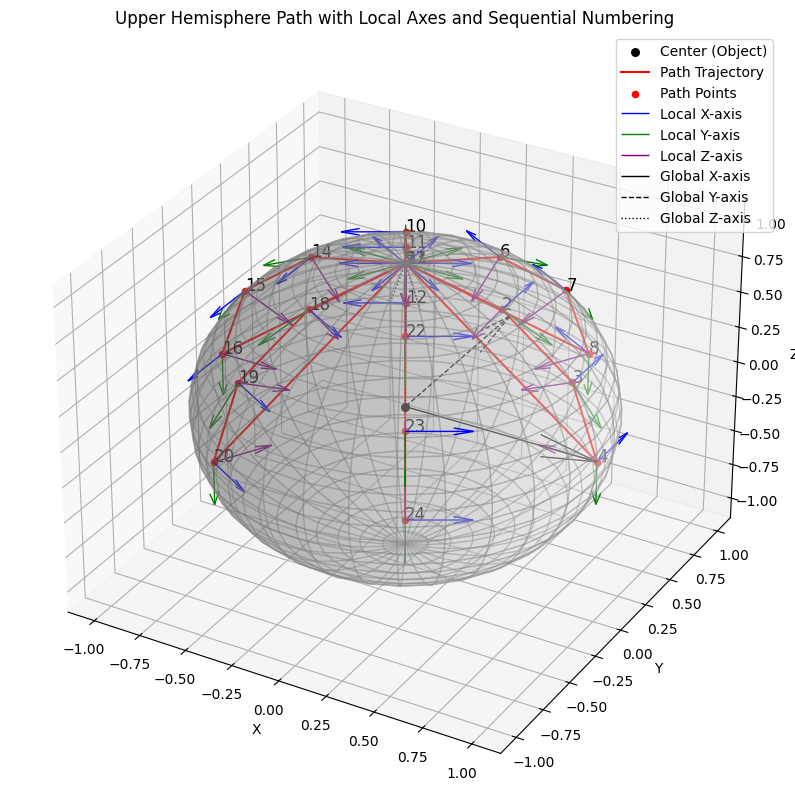

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def generate_upper_hemisphere_path_with_orientation(radius=1.0, num_points=5):
    """
    Generate 6D points (3D position + 3D orientation) along the upper hemisphere of a sphere.

    Parameters:
        radius (float): Radius of the sphere.
        num_points (int): Number of points along the path.

    Returns:
        numpy.ndarray: Array of 6D points [x, y, z, theta, phi].
    """


    # Generate elevation angles (0 at the top, π/2 at the equator)
    theta = np.linspace(0, np.pi / 2, np.int32(num_points/2)+1)  
    # Generate azimuthal angles (full circle around Z-axis)
    phi = np.linspace(0, 2 * np.pi, num_points+1)
    phi = phi[:-1]

    # Create a meshgrid for all combinations of theta and phi
    theta, phi = np.meshgrid(theta, phi)
    
    # Convert spherical to Cartesian coordinates
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    # Flatten all arrays into a list of points
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten(), theta.flatten(), phi.flatten()))

    return points


def visualize_sphere_with_path(radius=1.0, path_points=None):
    """
    Visualize the sphere, path, and points along the upper hemisphere.

    Parameters:
        radius (float): Radius of the sphere.
        path_points (np.ndarray): Array of 6D points along the path.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create the sphere
    phi = np.linspace(0, 2 * np.pi, 30)
    theta = np.linspace(0, np.pi, 30)
    phi, theta = np.meshgrid(phi, theta)
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    ax.plot_surface(x, y, z, color='white', alpha=0.3, edgecolor='gray')
    ax.scatter(0, 0, 0, color='black', s=30, label="Center (Object)")
    
    axis = []

    if path_points is not None:
        
        path_x, path_y, path_z, theta_v, phi_v = path_points.T
        ax.plot(path_x, path_y, path_z, color='red', label="Path Trajectory")

        # Initialize rolling frame
        prev_x_axis = np.array([0, 1, 0])  # Initial reference x-axis
        
        # Plot and label each point with its sequential number
        for index, (x, y, z, theta, phi) in enumerate(path_points):
            ax.scatter(x, y, z, color='red', s=20, label="Path Points" if index == 0 else "")
            ax.text(x, y, z, str(index + 1), color='black', fontsize=12)  # Label with sequential number

            # Compute local axes
            point = np.array([x, y, z])
            # Normalize the position vector (local z-axis points toward center)
            local_z_axis = -point / np.linalg.norm(point)
            
            # Local x-axis (tangential to azimuthal direction)
            tangent_azimuth = np.array([-np.sin(phi), np.cos(phi), 0]) 
            local_x_axis = tangent_azimuth / np.linalg.norm(tangent_azimuth)
            
            if np.dot(local_x_axis, prev_x_axis) < 0:  # Check for a flip
                local_x_axis = -local_x_axis
            # Update rolling reference
            prev_x_axis = local_x_axis
            
            # Local y-axis (orthogonal to x-axis and z-axis)
            local_y_axis = np.cross(local_z_axis, local_x_axis)
            local_y_axis /= np.linalg.norm(local_y_axis)
            if index == 10:
                print(index)
                print('y',local_y_axis)
                print('x',local_x_axis)
                print('z',local_z_axis)
            
            # Store local axes for convert to colmap poses
            axis.append(np.column_stack((local_y_axis, local_x_axis, local_z_axis)))  # Stack as rows

            # Plot local axes at this point
            ax.quiver(
                point[0], point[1], point[2],
                local_x_axis[0], local_x_axis[1], local_x_axis[2],
                color='blue', label="Local X-axis" if index == 0 else ""
                ,length=0.3, linewidth=1
            )
            ax.quiver(
                point[0], point[1], point[2],
                local_y_axis[0], local_y_axis[1], local_y_axis[2],
                color='green', label="Local Y-axis" if index == 0 else ""
                ,length=0.3, linewidth=1
            )
            ax.quiver(
                point[0], point[1], point[2],
                local_z_axis[0], local_z_axis[1], local_z_axis[2],
                color='purple', label="Local Z-axis" if index == 0 else ""
                ,length=0.3, linewidth=1
            )


    # Global axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='black', linewidth=1, label="Global X-axis")
    ax.quiver(0, 0, 0, 0, 1, 0, color='black', linewidth=1, linestyle='dashed', label="Global Y-axis")
    ax.quiver(0, 0, 0, 0, 0, 1, color='black', linewidth=1, linestyle='dotted', label="Global Z-axis")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Upper Hemisphere Path with Local Axes and Sequential Numbering")
    ax.legend()
    # plt.show()
    axis = np.array(axis)
    return axis


# Generate path points with position and orientation
radius = 1.0
num_points = 6
path_points = generate_upper_hemisphere_path_with_orientation(radius, num_points)

# Visualize the sphere and path
axis = visualize_sphere_with_path(radius, path_points)

print(axis[10])
print(axis[10].shape)
